In [18]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'  #change dir to your project folder

import numpy as np
X_train = np.load('gdrive/My Drive/dataset1/acc+gyr/trainX.npy')
y_train = np.load('gdrive/My Drive/dataset1/acc+gyr/trainy.npy')
X_test = np.load('gdrive/My Drive/dataset1/acc+gyr/testX.npy')
y_test = np.load('gdrive/My Drive/dataset1/acc+gyr/testy.npy')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Mounted at /content/drive
Mounted at /content/gdrive
(33104, 128, 6) (33104, 118) (3740, 128, 6) (3740, 118)


In [19]:
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import save, load
from pandas import read_csv
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Input ,concatenate
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Conv1D, concatenate,GlobalMaxPooling1D,TimeDistributed, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate
from tensorflow.keras import regularizers

In [20]:
from sklearn.model_selection import train_test_split
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
validation_data=(X_validation, y_validation)

In [21]:
CNN_model= Sequential()
CNN_model.add(Conv1D(filters=32, kernel_size=9, strides=2, activation='relu', input_shape=(n_timesteps,n_features)))
CNN_model.add(MaxPooling1D(pool_size=2 ,strides=2))
CNN_model.add(Dropout(0.5))
CNN_model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu'))
CNN_model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2 ,strides=2))
CNN_model.add(Dropout(0.5))
CNN_model.add(Conv1D(filters=128, kernel_size=1, strides=1, activation='relu'))
CNN_model.add(Flatten())
CNN_model.add(Dense(n_outputs, activation='relu'))
CNN_model.summary()

LSTM_model= Sequential()
LSTM_model.add(LSTM(512,input_shape=(n_timesteps,n_features),return_sequences=True))
LSTM_model.add(LSTM(256))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(128, activation='relu'))
LSTM_model.add(Dense(n_outputs, activation='relu'))
LSTM_model.summary()

inputs = Input(shape=(n_timesteps,n_features))
mergedInput= concatenate([CNN_model(inputs),LSTM_model(inputs)])
out = Dense(n_outputs, activation='softmax')(mergedInput)
model3 = Model(inputs,out)
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model3.layers[0].set_weights(LSTM_model.layers[4].get_weights())
model3.summary()
callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 60, 32)            1760      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 30, 32)           0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 30, 32)            0         
                                                                 
 conv1d_13 (Conv1D)          (None, 28, 64)            6208      
                                                                 
 conv1d_14 (Conv1D)          (None, 26, 128)           24704     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 13, 128)          0         
 1D)                                                  

In [22]:
history = model3.fit(X_training, y_training, epochs=200, verbose=True, validation_data=(X_validation, y_validation), batch_size=128,callbacks=callbacks)

Epoch 1/200
207/207 [==============================] - 20s 84ms/step - loss: 2.1099 - accuracy: 0.4709 - val_loss: 0.8163 - val_accuracy: 0.7863
Epoch 2/200
207/207 [==============================] - 17s 82ms/step - loss: 0.6634 - accuracy: 0.8220 - val_loss: 0.4756 - val_accuracy: 0.8716
Epoch 3/200
207/207 [==============================] - 17s 84ms/step - loss: 0.4641 - accuracy: 0.8729 - val_loss: 0.3470 - val_accuracy: 0.9071
Epoch 4/200
207/207 [==============================] - 17s 83ms/step - loss: 0.3819 - accuracy: 0.8942 - val_loss: 0.3282 - val_accuracy: 0.9094
Epoch 5/200
207/207 [==============================] - 17s 82ms/step - loss: 0.3088 - accuracy: 0.9131 - val_loss: 0.2657 - val_accuracy: 0.9272
Epoch 6/200
207/207 [==============================] - 17s 82ms/step - loss: 0.2592 - accuracy: 0.9261 - val_loss: 0.2462 - val_accuracy: 0.9358
Epoch 7/200
207/207 [==============================] - 17s 82ms/step - loss: 0.2386 - accuracy: 0.9314 - val_loss: 0.2410 - val_ac

In [23]:
loss, accuracy = model3.evaluate(X_validation, y_validation, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Validation Accuracy:  0.9657
Testing Accuracy: 0.9037


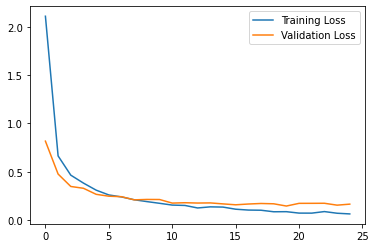

In [24]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()